In [1]:
from pyquil.quil import *
from pyquil.api import get_qc
from pyquil.gates import *
from pyquil.latex import display, to_latex
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix

In [2]:
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix

In [3]:
from functions import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
qc = get_qc("9q-square-qvm")

# Programmable recipe
![alt text](rotation_definition.png "Title")
$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})$$
![alt text](programmble_decomposition.png "Title")

In [6]:
G = Program(PHASE(- np.pi/2, qubit=0), CNOT(control=0, target=1))

$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})\\
U(2) = R(\theta, \phi) R_z(\phi_z)\\
or\\
U(2) = R_z(\theta) R_y(\phi) R_z(\psi)
$$

In [7]:
def arbitary_single_qubit_circuit(theta, phi, si, qubit):
    return Program( RZ(si, qubit = qubit), RY(phi, qubit = qubit), RZ(theta, qubit = qubit) )

def r_theta_phi_rotation(theta, phi, qubit):
    return arbitary_single_qubit_circuit( - phi/2, theta, phi/2, qubit)

In [8]:
def give_random_single_qubit_gate(qubit):
    theta, si = np.random.uniform(0,2*np.pi, size = 2)
    
    phi_range = np.linspace(0,np.pi)
    p_phi = np.sin(phi_range) / np.sum(np.sin(phi_range))
    phi = np.random.choice(phi_range, p = p_phi)
    return arbitary_single_qubit_circuit(theta, phi, si, qubit = qubit)

def normalized_abs_angle_dist(angle_range):
    dist = np.pi - np.abs( np.pi - angle_range )
    dist /= np.sum(dist)
    return dist

def give_v_circuit(alpha, beta, delta, qubits = [0,1]):
    prog = Program(G,  r_theta_phi_rotation(alpha, 0, qubit =qubits[0]),
                   r_theta_phi_rotation(3*np.pi/2,0, qubit =qubits[1]), G)
    prog += Program( r_theta_phi_rotation(beta, np.pi/2, qubit = qubits[0]), 
                    r_theta_phi_rotation(3*np.pi/2, delta, qubit = qubits[1]), G)
    return prog

def give_random_two_quibt_circuit(qubits):
    a,b,c,d = [give_random_single_qubit_gate(qubit=qubit) for _ in range(2) for qubit in qubits]
    
    angles_range = np.linspace(0,2*np.pi)
    alpha, beta, delta = np.random.choice(angles_range, p = normalized_abs_angle_dist(angles_range),
                                          size = 3)
    
    prog = Program(a, b )
    prog += give_v_circuit(alpha, beta, delta, qubits = [0,1])
    prog += Program(c, d )
    return prog

In [9]:
program_unitary(give_random_two_quibt_circuit([0,1]), n_qubits=2)

array([[-0.20831292-0.20199905j,  0.60722368+0.33117225j,
         0.00450763-0.13430205j, -0.55748667+0.32948096j],
       [ 0.78558087-0.08045397j,  0.26905857-0.13152792j,
         0.46501864-0.24363702j,  0.06292134+0.08448262j],
       [-0.19533541+0.05552718j, -0.01702031-0.62855328j,
         0.34855893+0.07143562j, -0.5604572 -0.35026168j],
       [ 0.43486446-0.2486879j , -0.08962421-0.16885146j,
        -0.44429355+0.61834308j, -0.30560657+0.19840265j]])

In [10]:
sample = give_random_two_quibt_circuit([0,1])
print( qc.compile( sample ) , len(sample), len(qc.compile( sample )))

RZ(-2.622817150656585) 0
RX(pi/2) 0
RZ(0.79881422039391) 0
RX(-pi/2) 0
RZ(2.035012010273592) 0
RZ(0.25527685183273346) 1
RX(pi/2) 1
RZ(1.7814542805641687) 1
RX(-pi/2) 1
RZ(-1.4934980606036556) 1
XY(pi) 0 1
RZ(-pi) 0
RX(pi/2) 0
RZ(3.126821433775117) 0
RX(-pi/2) 0
RZ(-pi/2) 0
RZ(pi/2) 1
RX(pi/2) 1
RZ(pi/2) 1
RX(-pi/2) 1
RZ(1.0281625116393769) 1
XY(pi) 0 1
RX(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0
RX(pi/2) 1
RZ(1.5464624798649638) 1
RX(-pi/2) 1
XY(pi) 0 1
RZ(-2.0166388855289763) 0
RX(pi/2) 0
RZ(0.8120954577058715) 0
RX(-pi/2) 0
RZ(-4.184843140276936) 0
RZ(0.16799061764577322) 1
RX(pi/2) 1
RZ(1.0299597191225138) 1
RX(-pi/2) 1
RZ(-0.4939599425637442) 1
HALT
 30 39


# Visualization
## single-qubit

In [11]:
num_samples = 2021

single_qubit_unitary_samples = [program_unitary(give_random_single_qubit_gate(qubit=0), n_qubits = 1) for _ in range(num_samples)]

In [12]:
single_zero_state_density_matrix = np.array([[1,0],[0,0]])
single_final_states = np.array( [np.dot( np.dot(u,single_zero_state_density_matrix), u.conj().T ) for u in single_qubit_unitary_samples] )

In [13]:
single_qubit_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in single_final_states])

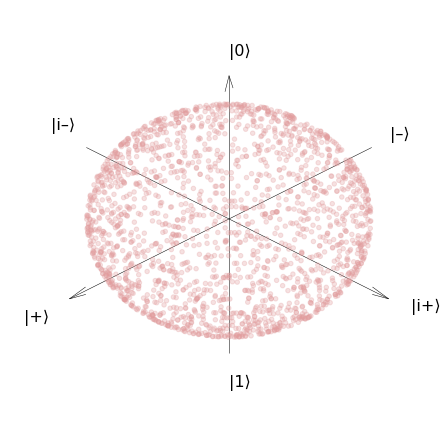

In [14]:
plot_bloch_sphere(single_qubit_bloch_vectors)

## Two qubits

In [15]:
num_samples = 2021

two_qubit_unitary_samples = [program_unitary(give_random_two_quibt_circuit([0,1]), n_qubits = 2) for _ in range(num_samples)]

In [16]:
two_zero_state_density_matrix = np.kron( np.array([[1,0],[0,0]]) , np.array([[1,0],[0,0]]) )
two_final_states = np.array( [np.dot( np.dot(u,two_zero_state_density_matrix), u.conj().T ) for u in two_qubit_unitary_samples] )

In [17]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

two_qubit_unitary_basis = np.array([ [ np.kron(x,y) for x in [X,Y,Z] ] for y in [X,Y,Z] ])
# two_qubit_unitary_basis[0]

In [18]:
# Used the mixed state simulator so we could have the density matrix for this part!
def reduce_to_bloch_vector(rho, sigma_arr:np.array):
    """Reduce a density matrix to a Bloch vector."""
    ax = np.trace(np.dot(rho, sigma_arr[0])).real
    ay = np.trace(np.dot(rho, sigma_arr[1])).real
    az = np.trace(np.dot(rho, sigma_arr[2])).real
    return [ax, ay, az]

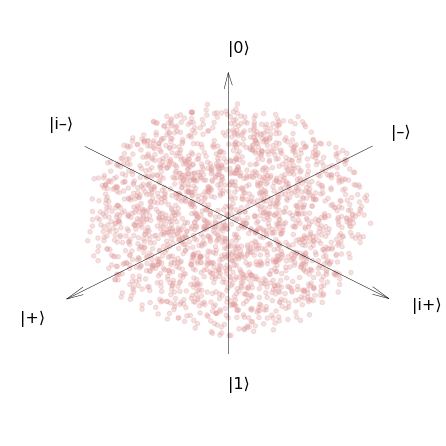

In [19]:
two_qubit_bloch_vectors = np.array([reduce_to_bloch_vector(s,two_qubit_unitary_basis[2]) for s in two_final_states])
plot_bloch_sphere(two_qubit_bloch_vectors)

### Verification of Haar distribution
we need to find out whether the distribution of the points is really uniform over the total space. To do so we first compute the radial distance of points and plot their cumulative histogram. If it grows with the power of 3 then we can be sure that the density of points is uniform in the sphere.

In [20]:
r_bloch_vectors = np.sqrt( two_qubit_bloch_vectors[:,0]**2 + two_qubit_bloch_vectors[:,1]**2 + two_qubit_bloch_vectors[:,2]**2)

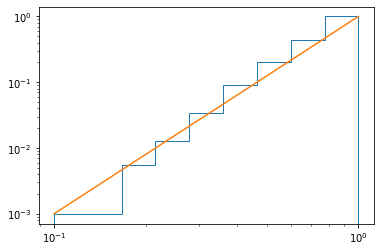

In [21]:
n_bins = 10

fig, ax = plt.subplots()

bins = np.logspace(np.log10(0.1),np.log10(1),n_bins)
# plot the cumulative histogram
pop, bins, hist_ = ax.hist( r_bloch_vectors, bins, histtype='step',
                           cumulative=True, density = True, label='Empirical')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.plot(np.linspace(0,1,10), np.linspace(0,1,10)**slope)
ax.plot(bins, bins**3)
plt.show()


In [22]:
non_zero_mask = pop != 0
regression_pop = pop[non_zero_mask]
regression_bins = np.array( bins[:-1] ) [non_zero_mask]
exp, intercept = np.polyfit(np.log(regression_bins), np.log(regression_pop), deg = 1)
exp, intercept

(3.5950863468910175, 1.0908997479597613)

In [23]:
def exponent_of_dist(data):
    n_bins = 100
    bins = np.logspace(np.log10(0.1),np.log10(1),n_bins)
    # plot the cumulative histogram
    pop, bins, hist_ = plt.hist( data, bins, cumulative=True, density = True)
    # extrapolate the exponent
    non_zero_mask = pop != 0
    regression_pop = pop[non_zero_mask]
    regression_bins = np.array( bins[:-1] ) [non_zero_mask]
    exp, intercept = np.polyfit(np.log(regression_bins), np.log(regression_pop), deg = 1)
    plt.close()
    return exp

In [24]:
exp_list = []
for i in range(len(two_qubit_unitary_basis)):
    two_qubit_bloch_vectors = np.array([reduce_to_bloch_vector(s,two_qubit_unitary_basis[i]) for s in two_final_states])
    r_bloch_vectors = np.sqrt( two_qubit_bloch_vectors[:,0]**2 + two_qubit_bloch_vectors[:,1]**2 + two_qubit_bloch_vectors[:,2]**2)
    exp_list.append(exponent_of_dist(r_bloch_vectors))
exp_list

[3.5613178133850067, 3.1273899538835583, 3.685157866605469]

# Matrix decomposition verification


In [25]:
from scipy.stats import unitary_group
import cmath

In [26]:
u_matrix = unitary_group.rvs(4)
lambda_unitary = np.array([ [1, 1j , 0 , 0],[0, 0, 1j, 1],[0, 0, 1j, -1],[1, -1j, 0, 0] ])

In [27]:
def matrix_in_magic_basis(matrix):
    return np.dot( lambda_unitary, np.dot(matrix, lambda_unitary.conj().transpose()) )

def matrix_out_magic_basis(magic_matrix):
    return np.dot( lambda_unitary.conj().transpose(), np.dot(magic_matrix, lambda_unitary) )

u_magic_matrix = matrix_in_magic_basis(u_matrix)

In [28]:
u_u_T = np.dot(u_magic_matrix, u_magic_matrix.transpose())

In [29]:
u_u_T_eigen_values, u_u_T_eigen_vectors = np.linalg.eig(u_u_T)

#### V Gate:

In [30]:
eigen_values_phases = [cmath.phase(x) for x in u_u_T_eigen_values]
alpha, beta, delta = np.array([eigen_values_phases[0] + eigen_values_phases[1],
                               eigen_values_phases[0] + eigen_values_phases[2],
                               eigen_values_phases[1] + eigen_values_phases[2] ]) / 2
v_matrix = program_unitary(give_v_circuit(alpha, beta, delta), n_qubits=2)
v_matrix

array([[ 0.10322901+0.27940654j,  0.16671333+0.44874593j,
         0.75759386-0.27822751j, -0.16471811+0.06015348j],
       [-0.4471716 -0.16330281j,  0.27906386+0.10248663j,
        -0.06140977+0.16529803j, -0.28024289+0.75852418j],
       [-0.75906671-0.27877004j,  0.16563621+0.06049167j,
         0.10302916-0.27886401j,  0.16579523-0.4462535j ],
       [ 0.06107158+0.16437993j,  0.27970036+0.75705133j,
        -0.44966403+0.16422091j,  0.27960639-0.10268648j]])

In [31]:
v_magic_matrix = matrix_in_magic_basis(v_matrix)
v_v_T = np.dot(v_magic_matrix, v_magic_matrix.transpose())

#### K and L

In [32]:
v_v_T_eigen_values, v_v_T_eigen_vectors = np.linalg.eig(v_v_T)

In [33]:
k_matrix = np.copy(v_v_T_eigen_vectors)
l_matrix = np.copy(u_u_T_eigen_vectors)

#### AB
$$ A \otimes B = \Lambda ( v^\dagger k^T l u ) \Lambda^\dagger $$

In [34]:
a_tensor_b = matrix_in_magic_basis( np.dot( v_magic_matrix.conjugate().transpose(),
                                           np.dot(k_matrix.transpose(),np.dot(l_matrix, u_magic_matrix))) )
a_tensor_b

array([[-2.54347667+0.7782235j ,  4.78922431-2.30851558j,
         2.80772697-2.03636723j, -4.02332202+0.6647847j ],
       [ 2.02479234+5.05549624j, -0.53472949+2.93802572j,
        -2.11088555-1.94378273j, -3.48490958-2.24622329j],
       [ 1.17601245+4.86147873j,  0.57180204-0.49799152j,
         3.74265685+4.48594561j,  1.69936447+1.17857464j],
       [-0.4632579 +1.42677247j,  4.30911356+2.76997163j,
        -1.32562368-2.80130009j,  4.85435886+1.5294279j ]])

#### CD
$$ C \otimes D = \Lambda ( l^T k ) \Lambda^\dagger $$

In [35]:
c_tensor_d = matrix_in_magic_basis( np.dot(l_matrix.transpose(), k_matrix) )
c_tensor_d

array([[ 1.02620879-1.3175527j , -0.35800516+0.51077712j,
        -0.80699057-0.26465222j,  0.30600064+0.0835371j ],
       [-0.74820062-0.40183381j,  0.28665191+0.13581429j,
         0.24631576-1.6517803j , -0.06080337+0.62077686j],
       [ 0.06080337+0.62077686j,  0.24631576+1.6517803j ,
         0.28665191-0.13581429j,  0.74820062-0.40183381j],
       [ 0.30600064-0.0835371j ,  0.80699057-0.26465222j,
         0.35800516+0.51077712j,  1.02620879+1.3175527j ]])

#### Construct U
$$ U = (A \otimes B) V (C \otimes D) $$

In [36]:
u_constructed = np.dot(a_tensor_b, np.dot(v_matrix, c_tensor_d))
u_constructed

array([[ -8.18295655+11.83581732j,   2.49522587 -1.88829358j,
         -3.97600243 +1.97484053j,  -3.95350867 +1.95499987j],
       [ -0.57380522 +4.38796495j, -11.24262288 +6.40955449j,
         -2.17356169 -0.94737148j,   2.0820966  -7.67987916j],
       [ -5.18815585 +0.40715568j,   0.20879282 +4.34021766j,
         10.43142129 +8.91485357j,   4.52868332 +1.11267362j],
       [ -0.36072503 -1.46843531j,  -6.94570432 -3.40666186j,
          6.50909248 +0.10989688j, -12.23477517 +1.33990151j]])

In [37]:
u_matrix

array([[ 0.30256884+0.23456126j, -0.40200206-0.4563343j ,
         0.3186884 +0.543775j  , -0.04535605-0.29030285j],
       [-0.03858042-0.31960384j,  0.24870055-0.10081386j,
        -0.1246637 +0.34460795j, -0.81669366+0.15187273j],
       [ 0.13582232+0.58788732j,  0.31128016-0.29051051j,
         0.25171324-0.51275884j, -0.35801209+0.01397333j],
       [-0.49290019+0.37787331j, -0.60662695+0.09407447j,
        -0.36718957-0.085682j  , -0.30696774-0.03187661j]])

#### Check Check
Given U and constructed U are allowed to be different by a phase factor. So we should have their dot to be an identity with a global phase shift.
$$ U_g U^{\dagger}_c  = e$$

In [40]:
np.dot(u_matrix, u_constructed.conjugate().transpose())

array([[-0.42253981-8.95333277e+00j,  3.37749837+4.41201483e+00j,
         4.10483526+1.87642665e+00j,  6.19325718+9.27679030e+00j],
       [ 2.04578508+3.16223617e+00j, -7.74479806-6.93099203e+00j,
        -2.07344681+6.87600537e+00j,  8.52125427+3.09904380e+00j],
       [ 6.6012746 -4.36901880e+00j, -3.77402531-1.02980031e+00j,
        -5.21241029-1.16481908e+01j,  3.89633663+9.09012228e-03j],
       [ 9.2565281 +3.62296207e+00j,  9.84893091+2.19109256e+00j,
        -3.02703895+3.46960852e+00j,  4.82937315-3.29613616e+00j]])

In [38]:
# np.linalg.eig(u_matrix)[0], np.linalg.eig(u_constructed)[0]

In [39]:
# u_constructed_phase = [cmath.phase(x) for x in u_u_T_eigen_values]